In [28]:
import keras
from keras import ops
from keras import layers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [22]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train = train[['text', 'target']] 
train

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


Summary Statistics of the lengths of the words
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64


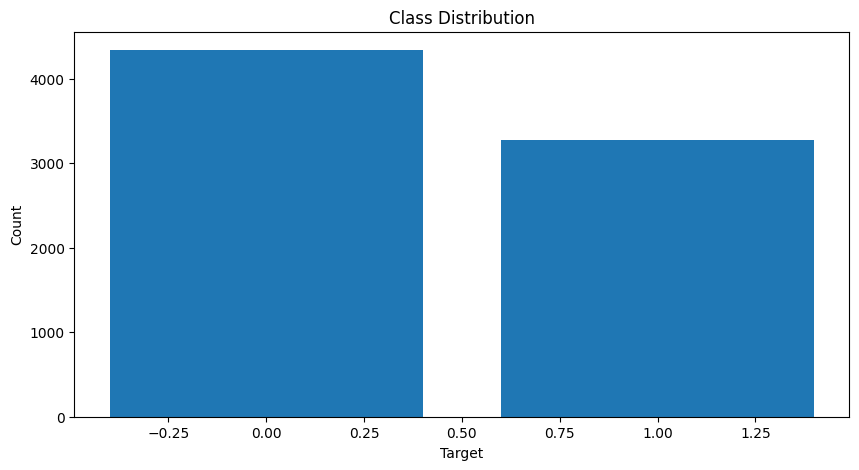

In [23]:
import matplotlib.pyplot as plt

def EDA(df):
    # Calculate length of each text
    df['length'] = df['text'].apply(lambda x: len(x))
    
    # Print summary statistics of text lengths
    print(f"Summary Statistics of the lengths of the words\n{df['length'].describe()}")
    
    # Count occurrences of each target class
    target_counts = df['target'].value_counts()
    
    # Plot class distribution
    plt.figure(figsize=(10, 5))
    plt.bar(target_counts.index, target_counts.values)
    plt.xlabel('Target')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()

# Call the function with your train DataFrame
EDA(train)

In [25]:
eng = spacy.load("en_core_web_sm") 
stop_words = set(stopwords.words('english'))

def engTokenize(text):
    """
    Tokenize an English text and return a list of tokens
    """
    return [token.text for token in eng.tokenizer(text)]

def preprocess(df):
    # Lowercase the text
    df['text'] = df['text'].str.lower()
    
    # Remove special characters
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
    
    # Remove stopwords and tokenize
    df['tokenized_texts'] = df['text'].apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words])
    
    return df

train = preprocess(train)
train

,text,target,length,tokenized_texts
0,our deeds are the reason of this earthquake ma...,1,69,"[deeds, reason, earthquake, may, allah, forgiv..."
1,forest fire near la ronge sask canada,1,38,"[forest, fire, near, la, ronge, sask, canada]"
2,all residents asked to shelter in place are be...,1,133,"[residents, asked, shelter, place, notified, o..."
3,13000 people receive wildfires evacuation orde...,1,65,"[13000, people, receive, wildfires, evacuation..."
4,just got sent this photo from ruby alaska as s...,1,88,"[got, sent, photo, ruby, alaska, smoke, wildfi..."
...,...,...,...,...
7608,two giant cranes holding a bridge collapse int...,1,83,"[two, giant, cranes, holding, bridge, collapse..."
7609,ariaahrary thetawniest the out of control wild...,1,125,"[ariaahrary, thetawniest, control, wild, fires..."
7610,m194 0104 utc5km s of volcano hawaii httptcozd...,1,65,"[m194, 0104, utc5km, volcano, hawaii, httptcoz..."
7611,police investigating after an ebike collided w...,1,137,"[police, investigating, ebike, collided, car, ..."


In [27]:
# Define a tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on your tokenized texts
tokenizer.fit_on_texts(train['tokenized_texts'])

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding token

# Convert tokenized texts to sequences of indices
train_sequences = tokenizer.texts_to_sequences(train['tokenized_texts'])

In [36]:
# Define the maximum sequence length
maxlen = 157  # You can set it based on the maximum length observed in your dataset

# Pad sequences to the defined maximum length
padded_train_sequences = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
target_tensor = tf.convert_to_tensor(train['target'].values)
num_classes = 2
target_one_hot = tf.one_hot(train['target'].values, depth=num_classes)

In [38]:
print(f'train tensor has shape: {padded_train_sequences.shape}')
print(f'target tensor has shape: {target_one_hot.shape}')

train tensor has shape: (7613, 157)
target tensor has shape: (7613, 2)


In [40]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    

In [43]:
# Example data
num_samples = 7613 # Number of samples in data
maxlen = 157 # Max sentence = the padding
vocab_size = 1000
num_classes = 2

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = tf.keras.layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.5513 - loss: 0.6971 - val_accuracy: 0.5345 - val_loss: 0.6918
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.5740 - loss: 0.6820 - val_accuracy: 0.5345 - val_loss: 0.6903
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.5812 - loss: 0.6745 - val_accuracy: 0.7452 - val_loss: 0.5385
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.7686 - loss: 0.5083 - val_accuracy: 0.7492 - val_loss: 0.5087
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.8162 - loss: 0.4234 - val_accuracy: 0.7433 - val_loss: 0.5586
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.8361 - loss: 0.3861 - val_accuracy: 0.7617 - val_loss: 0.5510
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.8521 - loss: 0.3650 - val_accuracy: 0.7603 - val_loss: 0.5681
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.8572 - loss: 0.3471 - 

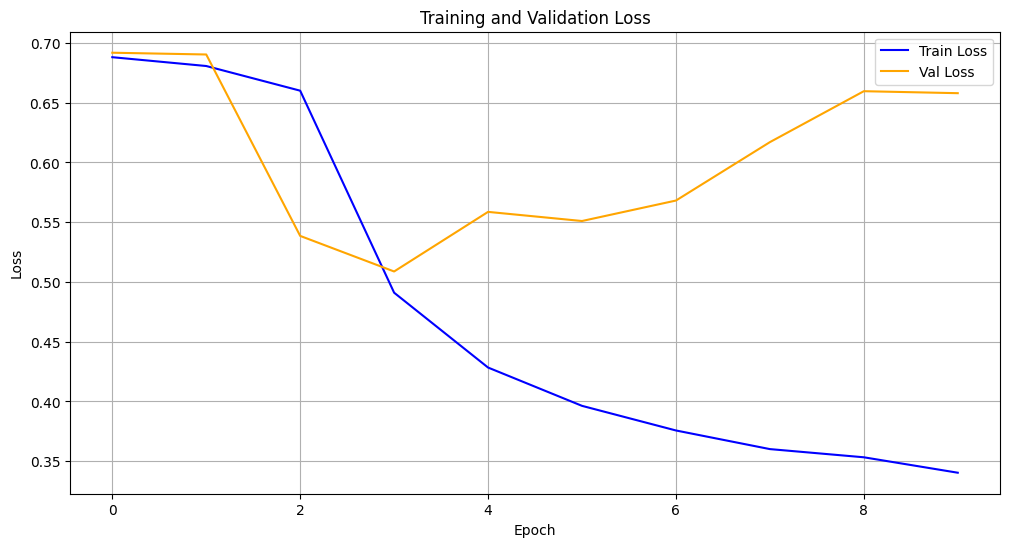

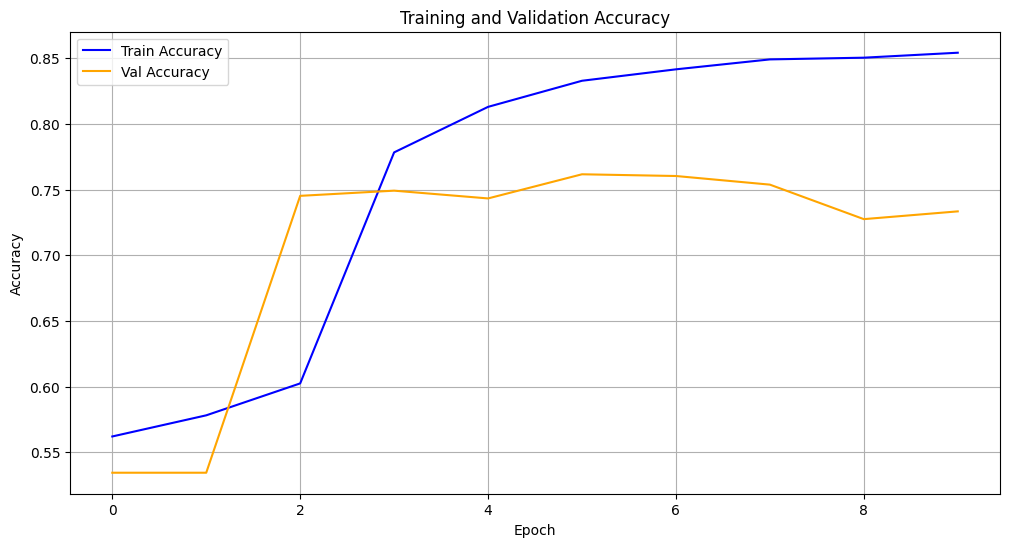

In [44]:
# Example usage: compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(padded_train_sequences, target_one_hot, epochs=10, batch_size=32, validation_split=0.2)
# Get training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get training and validation accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Val Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Train Accuracy', color='blue')
plt.plot(val_acc, label='Val Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Inference

In [47]:
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test = test[[text']]
test

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan
...,...
3258,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,Storm in RI worse than last hurricane. My city...
3260,Green Line derailment in Chicago http://t.co/U...
3261,MEG issues Hazardous Weather Outlook (HWO) htt...


In [48]:
# Preprocess the test data
test['text'] = test['text'].apply(lambda x: x.lower())
test['text'] = test['text'].apply(lambda x: ''.join(char.replace('@','').replace('#','') for char in x))
test['text'] = test['text'].apply(lambda x: ' '.join(word for word in word_tokenize(x) if word.lower() not in stop_words))

# Tokenize the text using the vocabulary
test_sequences = tokenizer.texts_to_sequences(test['text'])

# Pad sequences to ensure equal length
maxlen = 157  # Assuming you've set the maximum sequence length to 157 during training
padded_test_sequences = pad_sequences(test_sequences, maxlen=maxlen)

# Convert data to tensors
test_tensor = tf.convert_to_tensor(padded_test_sequences)

# Perform inference
predictions = model.predict(test_tensor)

# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)


102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step


In [58]:
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test['target'] = predicted_labels

test = test[['id', 'target']]
test

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [63]:
max_features = 30000  
maxlen = 157

# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, None, 128)      │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, None, 128)      │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,037,761 (15.40 MB)

 Trainable params: 4,037,761 (15.40 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# Convert the target data to binary encoding
target_binary = np.argmax(target_one_hot, axis=1)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 54s 249ms/step - accuracy: 0.6753 - loss: 0.5920 - val_accuracy: 0.7951 - val_loss: 0.4524
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 80s 240ms/step - accuracy: 0.9140 - loss: 0.2245 - val_accuracy: 0.7702 - val_loss: 0.4883
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - accuracy: 0.9663 - loss: 0.1047 - val_accuracy: 0.7682 - val_loss: 0.6501
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 81s 239ms/step - accuracy: 0.9860 - loss: 0.0503 - val_accuracy: 0.7617 - val_loss: 0.6718
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 82s 237ms/step - accuracy: 0.9916 - loss: 0.0312 - val_accuracy: 0.7630 - val_loss: 0.7736
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 81s 234ms/step - accuracy: 0.9939 - loss: 0.0150 - val_accuracy: 0.7446 - val_loss: 0.9224
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 82s 233ms/step - accuracy: 0.9932 - loss: 0.0174 - val_accuracy: 0.7466 - val_loss: 0.9607
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 44s 233ms/step - accuracy: 0.9947 - loss: 0

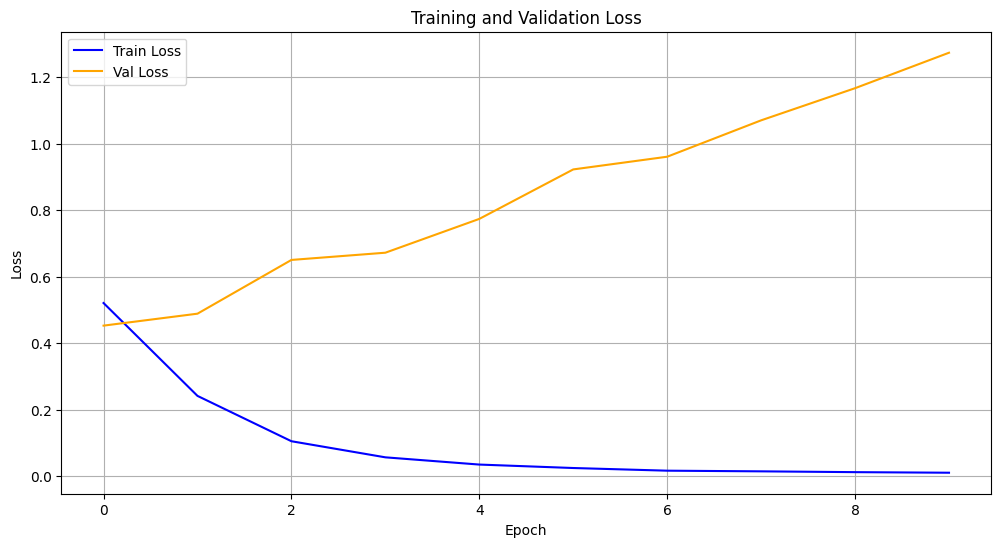

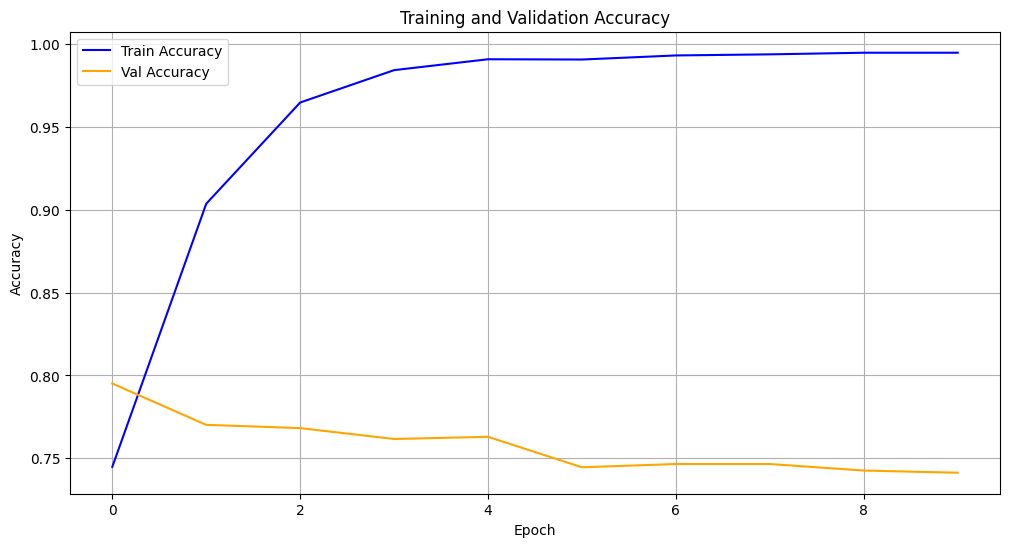

In [67]:
# Example usage: compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(padded_train_sequences, target_binary, epochs=10, batch_size=32, validation_split=0.2)
# Get training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get training and validation accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Val Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Train Accuracy', color='blue')
plt.plot(val_acc, label='Val Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()